In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from tqdm.auto import tqdm
import shutil
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
source = os.path.expanduser('~') + "/.kaggle/PetImages"

os.mkdir("images")
os.mkdir("images/test")
os.mkdir("images/test/dog")
os.mkdir("images/test/cat")
os.mkdir("images/train")
os.mkdir("images/train/dog")
os.mkdir("images/train/cat")



## Train/test data preparation

In [3]:
dest_cat = "images/train/cat/"
dest_dog = "images/train/dog/"

for imageName in tqdm(os.listdir(source)):
    category_dir = source + "/" + imageName
    print(category_dir)
    sample = np.random.choice(os.listdir(category_dir), 5000, replace=False)
    
    if imageName == "Dog":
        for fileName in sample:
            shutil.copy(category_dir + "/" + fileName, dest_dog)
    if imageName == "Cat":
        for fileName in sample:
                shutil.copy(category_dir + "/"  + fileName, dest_cat)

  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\arvenka/.kaggle/PetImages/Cat
C:\Users\arvenka/.kaggle/PetImages/Dog


In [112]:
# Test Data set
test_dog = np.random.choice(os.listdir(dest_dog), 200, replace=False)
test_cat = np.random.choice(os.listdir(dest_cat), 200, replace=False)

for imageName in test_dog:
  shutil.move(dest_dog + imageName, "images/test/dog")
for imageName in test_cat:
  shutil.move(dest_cat + imageName, "images/test/cat")

In [113]:
len(os.listdir(dest_dog)), len(os.listdir(dest_cat))


(4800, 4800)

In [114]:
test_dog = "images/test/dog/"
test_cat = "images/test/cat/"

len(os.listdir(test_dog)), len(os.listdir(test_cat))

(200, 200)

In [115]:
# Image Data Generator
idg = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True,
                                                      rotation_range=30,
                                                      rescale=1/255.0,
                                                      validation_split=0.1)

In [116]:
batch_size = 128

In [117]:
train_idg = idg.flow_from_directory("images/train", target_size=(150, 150),
                                    batch_size = batch_size,
                                    subset="training",)

Found 8640 images belonging to 2 classes.


In [118]:
val_idg = idg.flow_from_directory("images/test", target_size=(150, 150),
                                  batch_size = batch_size,
                                  subset="validation")

Found 40 images belonging to 2 classes.


## Modelling -

In [120]:
# Modelling -
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input((150,150,3), name="Input"))
# 1st chunk
model.add(tf.keras.layers.Conv2D(filters=16,
                                 kernel_size=(3,3),
                                 padding="valid",
                                 strides=(1,1),
                                 activation="relu",
                                 name="Conv1", ))
# (150, 150, 3), (3,3) --> (150 - 3 + 1)/1 = 148 = (148, 148, 16)
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2),
                                       strides =(2,2),
                                       padding="valid",
                                       name="Pool1"))
# 148 --> 74 ==> (74, 74, 16)
# 2nd Chunk
model.add(tf.keras.layers.Conv2D(filters=32,
                                 kernel_size=(3,3),
                                 padding="valid",
                                 strides=(1,1),
                                 activation="relu",
                                 name="Conv2"))
# (74, 74, 16) , (3,3) --> (74 - 3 + 1)/1 = 72 = (72, 72, 32)
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2),
                                       strides=(2,2),
                                       padding="valid",
                                       name="Pool2"))
# (72, 72, 32) --> 36 = (36, 36, 32)
# 3rd Chunk
model.add(tf.keras.layers.Conv2D(filters=32,
                                 kernel_size=(3,3),
                                 padding="valid",
                                 strides=(1,1),
                                 activation="relu",
                                 name="Conv3"))
# (36, 36, 32), (3,3) --> 36 -3 + 1 = 34 = (34, 34, 32)
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2),
                                       strides=(2,2),
                                       padding="valid",
                                       name="Pool3"))
# (34, 34, 32) --> (17, 17, 32)
model.add(tf.keras.layers.Flatten(name="Flat"))
model.add(tf.keras.layers.Dense(64, activation="relu", name="Dense1"))
model.add(tf.keras.layers.Dense(2, activation="softmax", name="Output"))

In [121]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv1 (Conv2D)                       │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool1 (MaxPooling2D)                 │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv2D)                       │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool2 (MaxPooling2D)                 │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3 (Conv2D)                       │ (None, 34, 34, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool3 (MaxPooling2D)                 │ (None, 17, 17, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flat (Flatten)                       │ (None, 9248)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense1 (Dense)                       │ (None, 64)                  │         591,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 606,402 (2.31 MB)

 Trainable params: 606,402 (2.31 MB)

 Non-trainable params: 0 (0.00 B)

## Compile & Train the model

In [125]:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics = ["accuracy"])

In [126]:
# Callbacks to reduce learning rate and stop early if no improvement
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=0.5, min_lr=1e-5, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
]

In [127]:
history = model.fit(train_idg, epochs=30, batch_size=batch_size, validation_data=val_idg, callbacks=callbacks)

Epoch 1/30
 5/68 ━━━━━━━━━━━━━━━━━━━━ 3:49 4s/step - accuracy: 0.5413 - loss: 0.6910

C:\Users\arvenka\AppData\Local\anaconda3\envs\tensorflow\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))


68/68 ━━━━━━━━━━━━━━━━━━━━ 317s 4s/step - accuracy: 0.5038 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932 - learning_rate: 0.0100
Epoch 2/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 226s 3s/step - accuracy: 0.5268 - loss: 0.6882 - val_accuracy: 0.4750 - val_loss: 0.6903 - learning_rate: 0.0100
Epoch 3/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 221s 3s/step - accuracy: 0.5580 - loss: 0.6848 - val_accuracy: 0.5250 - val_loss: 0.6912 - learning_rate: 0.0100
Epoch 4/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 229s 3s/step - accuracy: 0.5851 - loss: 0.6804 - val_accuracy: 0.5500 - val_loss: 0.6883 - learning_rate: 0.0100
Epoch 5/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 224s 3s/step - accuracy: 0.5943 - loss: 0.6741 - val_accuracy: 0.5500 - val_loss: 0.6913 - learning_rate: 0.0100
Epoch 6/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 230s 3s/step - accuracy: 0.6019 - loss: 0.6693 - val_accuracy: 0.5750 - val_loss: 0.6825 - learning_rate: 0.0100
Epoch 7/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 233s 3s/step - accuracy: 0.5916 - loss: 0.6702 - val_accuracy: 0.50

## Model Evaluation

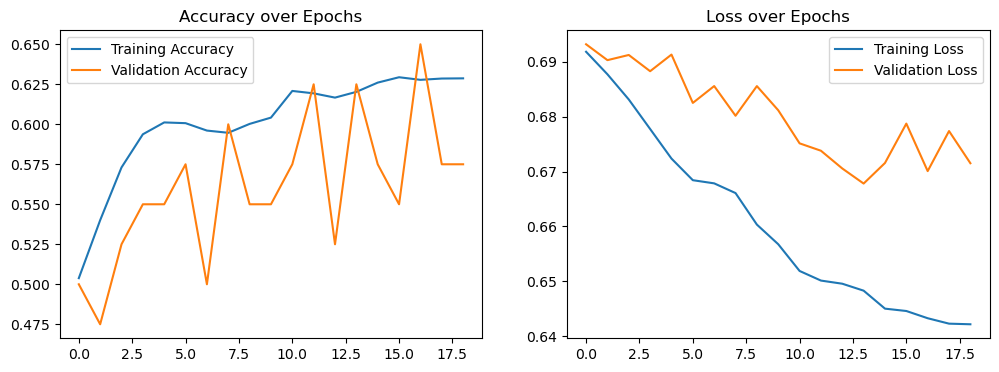

In [128]:
# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.show()

In [129]:
# Evaluate the model on test set
test_loss, test_acc = model.evaluate(val_idg)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step - accuracy: 0.5750 - loss: 0.6761
Test Accuracy: 57.50%


## Model prediction

(1, 150, 150, 3)

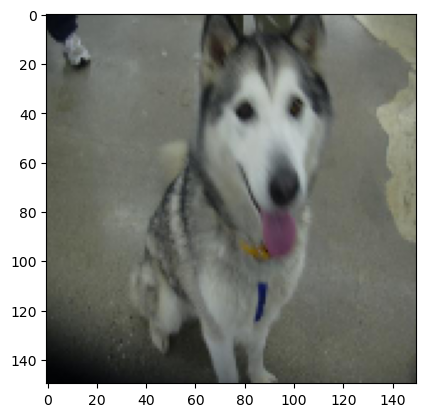

In [131]:
# Images in Test
test_image = "images/test/dog/759.jpg"
#test_image = "images/test/cat/2984.jpg"
test_image = cv2.imread(test_image)
test_image = cv2.resize(test_image, (150, 150))
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
plt.imshow(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image = test_image / 255.0
test_image.shape

In [132]:
model.predict(test_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


array([[0.6213305, 0.3786695]], dtype=float32)

In [133]:
train_idg.class_indices

{'cat': 0, 'dog': 1}

In [146]:
test_results = {}
for imageName in tqdm(os.listdir("images/test/dog/")):
  #print(imageName)
  test_image = "images/test/dog/" + imageName
  test_image = cv2.imread(test_image)
  test_image = cv2.resize(test_image, (150, 150))
  test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
  # plt.imshow(test_image)
  test_image = np.expand_dims(test_image, axis=0)
  test_image = test_image / 255.0
  result = model.predict(test_image)
  test_results[imageName] = result

for imageName in tqdm(os.listdir("images/test/cat/")):
  print(imageName)
  test_image = "images/test/cat/" + imageName
  test_image = cv2.imread(test_image)
  test_image = cv2.resize(test_image, (150, 150))
  test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
  # plt.imshow(test_image)
  test_image = np.expand_dims(test_image, axis=0)
  test_image = test_image / 255.0
  result = model.predict(test_image)
  test_results[imageName] = result

  0%|          | 0/198 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

  0%|          | 0/199 [00:00<?, ?it/s]

1005.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
10121.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
10146.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
10209.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
10311.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
10325.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
10326.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
10369.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
10391.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
10412.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
10464.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
10585.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
10623.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
10684.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
10696.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
10715.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
10746.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
10758.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
10778.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
10795.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
10841.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42m

In [147]:
test_results

{'10010.jpg': array([[0.47518268, 0.5248173 ]], dtype=float32),
 '10078.jpg': array([[0.60729593, 0.392704  ]], dtype=float32),
 '10154.jpg': array([[0.33842853, 0.66157156]], dtype=float32),
 '10176.jpg': array([[0.50622094, 0.49377915]], dtype=float32),
 '10301.jpg': array([[0.52334845, 0.4766516 ]], dtype=float32),
 '10376.jpg': array([[0.56810385, 0.4318961 ]], dtype=float32),
 '10409.jpg': array([[0.48331487, 0.5166851 ]], dtype=float32),
 '10495.jpg': array([[0.67486423, 0.32513586]], dtype=float32),
 '10578.jpg': array([[0.5574378, 0.4425622]], dtype=float32),
 '10623.jpg': array([[0.6922258 , 0.30777416]], dtype=float32),
 '1069.jpg': array([[0.4260767 , 0.57392335]], dtype=float32),
 '10691.jpg': array([[0.45810196, 0.541898  ]], dtype=float32),
 '10730.jpg': array([[0.36341512, 0.6365848 ]], dtype=float32),
 '10823.jpg': array([[0.36590883, 0.6340912 ]], dtype=float32),
 '10903.jpg': array([[0.47689402, 0.523106  ]], dtype=float32),
 '11071.jpg': array([[0.5334608 , 0.4665391

In [148]:
X_test = []
for imageName in tqdm(os.listdir("images/test/dog/")):
  test_image = "images/test/dog/" + imageName
  test_image = cv2.imread(test_image)
  test_image = cv2.resize(test_image, (150, 150))
  test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
  # plt.imshow(test_image)
  # test_image = np.expand_dims(test_image, axis=0)
  test_image = test_image / 255.0
  X_test.append(test_image)
    
for imageName in tqdm(os.listdir("images/test/cat/")):
  test_image = "images/test/cat/" + imageName
  test_image = cv2.imread(test_image)
  test_image = cv2.resize(test_image, (150, 150))
  test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
  # plt.imshow(test_image)
  # test_image = np.expand_dims(test_image, axis=0)
  test_image = test_image / 255.0
  X_test.append(test_image)
X_test = np.array(X_test)

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

In [149]:
X_test.shape

(397, 150, 150, 3)

In [150]:
model.predict(X_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


array([[0.47518274, 0.5248173 ],
       [0.60729605, 0.39270398],
       [0.33842853, 0.6615715 ],
       [0.50622094, 0.49377915],
       [0.5233484 , 0.47665164],
       [0.56810385, 0.43189615],
       [0.48331493, 0.5166851 ],
       [0.6748642 , 0.32513586],
       [0.5574378 , 0.4425622 ],
       [0.43095   , 0.56904995],
       [0.4260767 , 0.5739233 ],
       [0.45810193, 0.5418981 ],
       [0.36341512, 0.63658494],
       [0.36590886, 0.63409114],
       [0.476894  , 0.523106  ],
       [0.53346074, 0.46653923],
       [0.26473397, 0.7352661 ],
       [0.55245644, 0.4475436 ],
       [0.5452871 , 0.45471293],
       [0.5982829 , 0.40171716],
       [0.4706306 , 0.5293694 ],
       [0.40070263, 0.5992974 ],
       [0.46264365, 0.5373563 ],
       [0.43500894, 0.56499106],
       [0.63773966, 0.3622603 ],
       [0.50463647, 0.49536353],
       [0.6254781 , 0.37452194],
       [0.5819829 , 0.4180171 ],
       [0.5207334 , 0.47926655],
       [0.68197054, 0.31802943],
       [0.